# FlashCam Image Clustering

K-means clustering of FlashCam telescope images to separate:
- Complete muon rings
- Partial rings (arcs)
- Ring + shower combinations
- Shower-only events

## Setup

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import tables
import os
import random
from tqdm import tqdm

from tensorflow import keras
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny

np.random.seed(42)
random.seed(42)

2025-12-11 17:08:02.901572: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Parameters

In [21]:
# Data loading
DATA_DIR = '../data/flashcam'
MAX_IMAGES = 10000
TEST_SPLIT = 0.2

# Intensity filtering (percentile)
PIXEL_PERCENTILE_CUT = 20
INTENSITY_PERCENTILE_CUT = None

# Feature extraction
PCA_DIMENSIONS = 50

# K-means clustering
K_VALUES = [2, 3, 4, 5]
EXAMPLES_PER_CLUSTER = 8

# Hough transform (for complete ring detection)
HOUGH_MIN_RADIUS_FRACTION = 0.15  # Più grande
HOUGH_MAX_RADIUS_FRACTION = 0.45  # Più grande
HOUGH_QUALITY_PERCENTILE = 75     # Più stringente

## Load Data

In [3]:
def load_flashcam_data(data_dir, max_images=None, file_range=None):
    """
    Load FlashCam images from HDF5 files.
    
    Parameters:
    -----------
    data_dir : str
        Directory containing HDF5 files
    max_images : int or None
        Maximum number of images to load (None = all)
    file_range : int, tuple, 'all', or None
        - None: load files until max_images reached
        - int: load only that file index
        - (start, end): load files from start to end-1
        - 'all': load all files
    
    Returns:
    --------
    images : numpy array
    event_ids : numpy array
    """
    
    h5_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.h5')])
    if not h5_files:
        raise ValueError(f"No HDF5 files found in {data_dir}")
    
    print(f"Found {len(h5_files)} HDF5 files")
    
    # Determine which files to load
    if file_range is None:
        files_to_load = h5_files
        print(f"Loading until {max_images} images...")
    elif file_range == 'all':
        files_to_load = h5_files
        print(f"Loading ALL {len(files_to_load)} files")
    elif isinstance(file_range, int):
        files_to_load = [h5_files[file_range]]
        print(f"Loading file {file_range}: {h5_files[file_range]}")
    else:
        start_idx, end_idx = file_range
        files_to_load = h5_files[start_idx:end_idx]
        print(f"Loading files {start_idx} to {end_idx-1}")
    
    all_images = []
    all_event_ids = []
    total_loaded = 0
    
    for filename in files_to_load:
        if max_images is not None and total_loaded >= max_images:
            break
            
        filepath = os.path.join(data_dir, filename)
        with tables.open_file(filepath, 'r') as f:
            if max_images is None:
                n_to_load = len(f.root.images)
            else:
                remaining = max_images - total_loaded
                n_to_load = min(remaining, len(f.root.images))
            
            all_images.append(f.root.images[:n_to_load])
            all_event_ids.append(f.root.event_nr[:n_to_load])
            total_loaded += n_to_load
    
    images = np.concatenate(all_images)
    event_ids = np.concatenate(all_event_ids)
    
    print(f"Loaded {len(images)} images, shape {images[0].shape}")
    
    return images, event_ids

# Load data
all_images, all_event_ids = load_flashcam_data(DATA_DIR, MAX_IMAGES, file_range=0)

Found 162 HDF5 files
Loading file 0: flashcam_run178799_full_000.h5
Loaded 10000 images, shape (56, 56)


## Preprocess

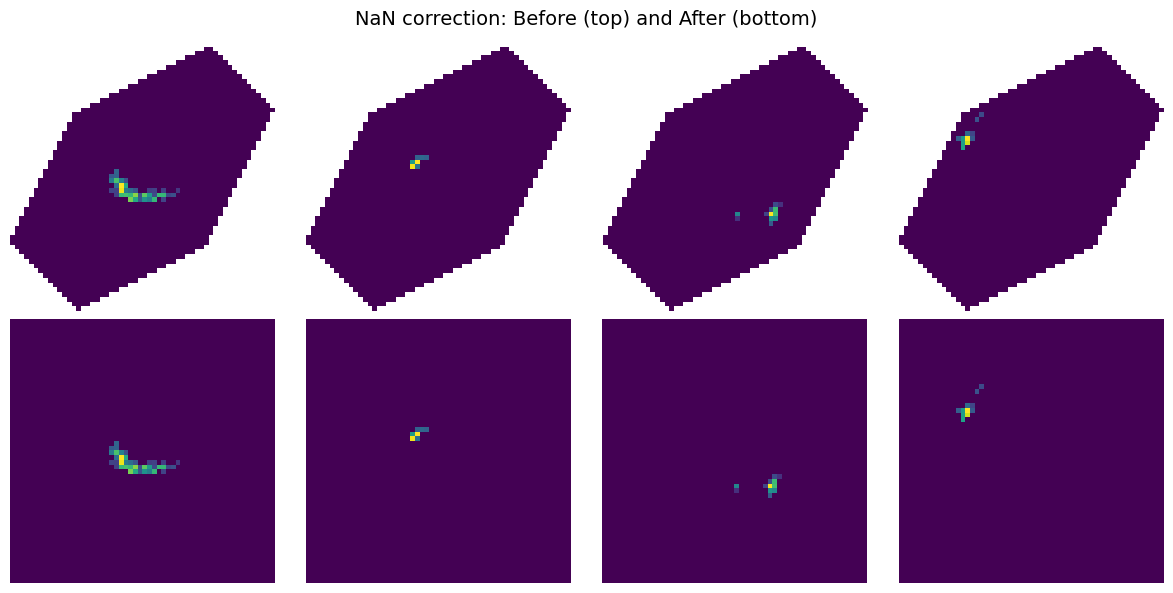

In [4]:
# Show sample images before NaN correction
indices = np.random.choice(len(all_images), 4, replace=False)
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.suptitle("NaN correction: Before (top) and After (bottom)", fontsize=14)

for i, idx in enumerate(indices):
    axes[0, i].imshow(all_images[idx], cmap='viridis')
    axes[0, i].axis('off')

# Replace NaN with 0 (pixels outside camera)
all_images = np.nan_to_num(all_images, nan=0.0)

for i, idx in enumerate(indices):
    axes[1, i].imshow(all_images[idx], cmap='viridis')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

## Filtering

In [5]:
def filter_intensity(images, event_ids, pixel_percentile=None, intensity_percentile=None):
    """Remove low-intensity events below the given percentiles."""
    
    if pixel_percentile is None and intensity_percentile is None:
        print("No intensity filtering")
        return images, event_ids
    
    active_pixels = (images > 0).sum(axis=(1, 2))
    total_intensity = images.sum(axis=(1, 2))
    
    keep = np.ones(len(images), dtype=bool)
    
    if pixel_percentile is not None:
        threshold = np.percentile(active_pixels, pixel_percentile)
        keep &= (active_pixels >= threshold)
        print(f"Pixel cut: {pixel_percentile}th percentile = {threshold:.1f}")
    
    if intensity_percentile is not None:
        threshold = np.percentile(total_intensity, intensity_percentile)
        keep &= (total_intensity >= threshold)
        print(f"Intensity cut: {intensity_percentile}th percentile = {threshold:.1f}")
    
    print(f"Kept {keep.sum()}/{len(images)} events ({keep.sum()/len(images)*100:.1f}%)")
    
    return images[keep], event_ids[keep]

# Apply intensity filter
all_images, all_event_ids = filter_intensity(
    all_images, 
    all_event_ids, 
    PIXEL_PERCENTILE_CUT, 
    INTENSITY_PERCENTILE_CUT
)

Pixel cut: 20th percentile = 7.0
Kept 8290/10000 events (82.9%)


## Normalization

Before normalization: [0.0, 290.9]


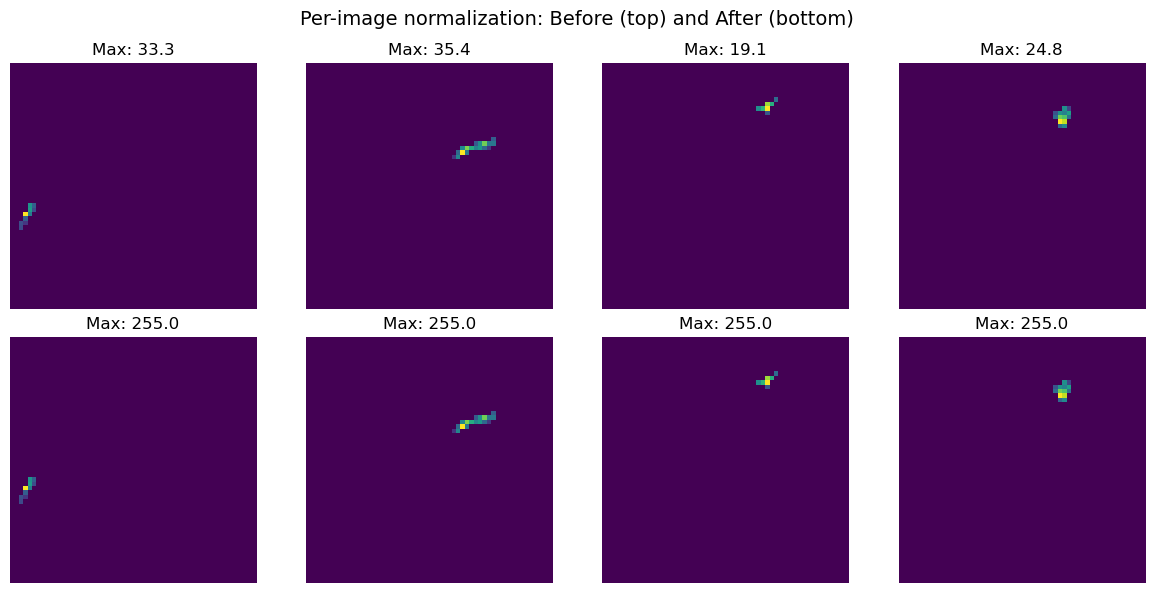

After normalization: each image normalized to [0, 255]


In [6]:
# Normalize each image individually to [0, 255]
print(f"Before normalization: [{all_images.min():.1f}, {all_images.max():.1f}]")

indices = np.random.choice(len(all_images), 4, replace=False)
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.suptitle("Per-image normalization: Before (top) and After (bottom)", fontsize=14)

for i, idx in enumerate(indices):
    axes[0, i].imshow(all_images[idx], cmap='viridis')
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Max: {all_images[idx].max():.1f}')

# Normalize each image to [0, 255]
normalized_images = []
for img in all_images:
    img_norm = (img - img.min()) / (img.max() - img.min() + 1e-8)
    img_norm = img_norm * 255.0
    normalized_images.append(img_norm)
all_images = np.array(normalized_images)

for i, idx in enumerate(indices):
    axes[1, i].imshow(all_images[idx], cmap='viridis')
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Max: {all_images[idx].max():.1f}')

plt.tight_layout()
plt.show()

print(f"After normalization: each image normalized to [0, 255]")

## Splitting

In [7]:
# Split into train/test
x_train, x_test, evt_train, evt_test = train_test_split(
    all_images, all_event_ids, test_size=TEST_SPLIT, random_state=42
)

print(f"Train: {len(x_train)}, Test: {len(x_test)}")

Train: 6632, Test: 1658


## VGG19

In [8]:
# Prepare images for VGG19 (resize to 224x224 and convert to RGB)
from skimage.transform import resize

def prepare_for_vgg19(images):
    """Resize to 224x224 and convert grayscale to RGB."""
    prepared = []
    
    print(f"Preparing {len(images)} images for VGG19...")
    for img in tqdm(images):
        # Resize to 224x224
        if img.shape != (224, 224):
            img_resized = resize(img, (224, 224), anti_aliasing=True, preserve_range=True)
        else:
            img_resized = img
        
        # Convert to RGB (stack grayscale 3 times)
        img_rgb = np.stack([img_resized, img_resized, img_resized], axis=-1)
        prepared.append(img_rgb)
    
    prepared = np.array(prepared)
    
    # Apply VGG19 preprocessing
    prepared = preprocess_input(prepared)
    
    print(f"Prepared shape: {prepared.shape}")
    return prepared

x_train_vgg = prepare_for_vgg19(x_train)
x_test_vgg = prepare_for_vgg19(x_test)

Preparing 6632 images for VGG19...


100%|██████████| 6632/6632 [00:08<00:00, 817.98it/s]


Prepared shape: (6632, 224, 224, 3)
Preparing 1658 images for VGG19...


100%|██████████| 1658/1658 [00:02<00:00, 809.37it/s]


Prepared shape: (1658, 224, 224, 3)


In [9]:
# Load VGG19 model (pre-trained on ImageNet)
print("Loading VGG19...")
vgg19 = VGG19(
    weights='imagenet',
    include_top=False,
    pooling='avg',
    input_shape=(224, 224, 3)
)

print(f"VGG19 output shape: {vgg19.output_shape}")
print(f"Each image -> {vgg19.output_shape[1]} features")

Loading VGG19...
VGG19 output shape: (None, 512)
Each image -> 512 features


In [10]:
# Extract features using VGG19
print("Extracting features...")
features_train = vgg19.predict(x_train_vgg, batch_size=32, verbose=1)
features_test = vgg19.predict(x_test_vgg, batch_size=32, verbose=1)

print(f"Train features: {features_train.shape}")
print(f"Test features: {features_test.shape}")

Extracting features...
208/208 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step
Train features: (6632, 512)
Test features: (1658, 512)


## PCA

In [11]:
# Apply PCA for dimensionality reduction
print(f"Applying PCA: {features_train.shape[1]} -> {PCA_DIMENSIONS} dimensions")

pca = PCA(n_components=PCA_DIMENSIONS, random_state=42)
features_train_pca = pca.fit_transform(features_train)
features_test_pca = pca.transform(features_test)

print(f"Train PCA: {features_train_pca.shape}")
print(f"Test PCA: {features_test_pca.shape}")
print(f"Explained variance: {pca.explained_variance_ratio_.sum():.2%}")

Applying PCA: 512 -> 50 dimensions
Train PCA: (6632, 50)
Test PCA: (1658, 50)
Explained variance: 93.32%


## K-means

In [12]:
# K-means clustering
kmeans_models = {}
kmeans_predictions = {}

print("Running K-means clustering...")
for k in K_VALUES:
    print(f"\nK-means with k={k}")
    
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    labels_train = kmeans.fit_predict(features_train_pca)
    labels_test = kmeans.predict(features_test_pca)
    
    kmeans_models[k] = kmeans
    kmeans_predictions[k] = {'train': labels_train, 'test': labels_test}
    
    # Show cluster sizes
    unique, counts = np.unique(labels_train, return_counts=True)
    for cluster, count in zip(unique, counts):
        print(f"  Cluster {cluster}: {count} ({count/len(labels_train)*100:.1f}%)")

Running K-means clustering...

K-means with k=2
  Cluster 0: 5965 (89.9%)
  Cluster 1: 667 (10.1%)

K-means with k=3
  Cluster 0: 1896 (28.6%)
  Cluster 1: 4411 (66.5%)
  Cluster 2: 325 (4.9%)

K-means with k=4
  Cluster 0: 260 (3.9%)
  Cluster 1: 2943 (44.4%)
  Cluster 2: 969 (14.6%)
  Cluster 3: 2460 (37.1%)

K-means with k=5
  Cluster 0: 1139 (17.2%)
  Cluster 1: 2182 (32.9%)
  Cluster 2: 305 (4.6%)
  Cluster 3: 2932 (44.2%)
  Cluster 4: 74 (1.1%)


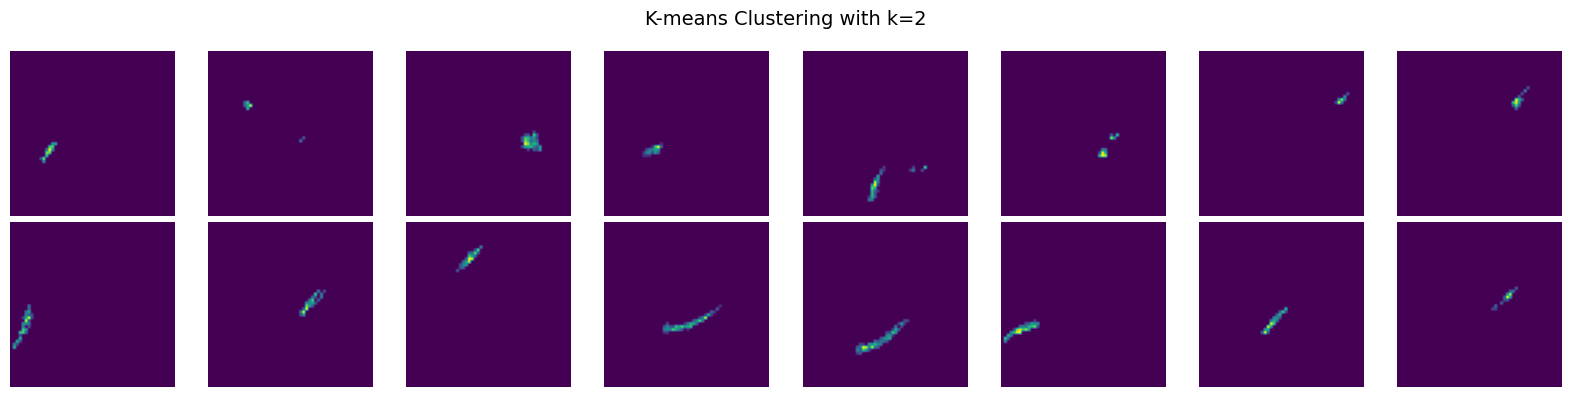


Cluster sizes for k=2:
  Cluster 0: 5965 events (89.9%)
  Cluster 1: 667 events (10.1%)


In [31]:
# Visualize clustering results for any k value
k_to_visualize = 2  # Change this to see different k values

k_labels = kmeans_predictions[k_to_visualize]['train']
n_clusters = len(np.unique(k_labels))

fig, axes = plt.subplots(n_clusters, 8, figsize=(16, 2*n_clusters))
fig.suptitle(f"K-means Clustering with k={k_to_visualize}", fontsize=14)

# Handle case where n_clusters = 1
if n_clusters == 1:
    axes = axes.reshape(1, -1)

for cluster_id in range(n_clusters):
    cluster_indices = np.where(k_labels == cluster_id)[0]
    n_samples = min(8, len(cluster_indices))
    
    if n_samples > 0:
        sample_indices = np.random.choice(cluster_indices, n_samples, replace=False)
        
        for j in range(8):
            if j < n_samples:
                axes[cluster_id, j].imshow(x_train[sample_indices[j]], cmap='viridis')
            axes[cluster_id, j].axis('off')
            
        axes[cluster_id, 0].set_ylabel(f'Cluster {cluster_id}\n({len(cluster_indices)})', 
                                       fontsize=10, rotation=0, ha='right', va='center')

plt.tight_layout()
plt.show()

# Print cluster sizes
print(f"\nCluster sizes for k={k_to_visualize}:")
for cluster_id in range(n_clusters):
    count = (k_labels == cluster_id).sum()
    print(f"  Cluster {cluster_id}: {count} events ({count/len(k_labels)*100:.1f}%)")

In [14]:
# Save PDF with sample images from each cluster (K=2)
from matplotlib.backends.backend_pdf import PdfPages

results_dir = '../results'
os.makedirs(results_dir, exist_ok=True)

k2_labels = kmeans_predictions[2]['train']

for cluster_id in [0, 1]:
    cluster_indices = np.where(k2_labels == cluster_id)[0]
    n_total = len(cluster_indices)
    
    # Sample 100 random images
    n_sample = min(100, n_total)
    sample_indices = np.random.choice(cluster_indices, n_sample, replace=False)
    
    print(f"Saving Cluster {cluster_id}: {n_sample}/{n_total} images...")
    
    pdf_filename = os.path.join(results_dir, f'cluster_{cluster_id}_sample.pdf')
    
    n_cols = 10
    n_rows = 10  # 100 images total
    
    with PdfPages(pdf_filename) as pdf:
        fig = plt.figure(figsize=(20, 20))
        fig.suptitle(f'Cluster {cluster_id} - {n_sample} sample images (total: {n_total})', fontsize=16)
        
        for i, idx in enumerate(sample_indices):
            ax = fig.add_subplot(n_rows, n_cols, i + 1)
            ax.imshow(x_train[idx], cmap='viridis')
            ax.axis('off')
        
        plt.tight_layout()
        pdf.savefig(fig, dpi=100)
        plt.close(fig)
    
    print(f"  Saved to {pdf_filename}")

print("Done!")

Saving Cluster 0: 100/5965 images...
  Saved to ../results/cluster_0_sample.pdf
Saving Cluster 1: 100/667 images...
  Saved to ../results/cluster_1_sample.pdf
Done!


Applying K-means (k=2) to Cluster 1 from k=2 clustering...
Cluster 1 has 667 events

Sub-clustering results:
  Sub-cluster 0: 163 events
  Sub-cluster 1: 504 events


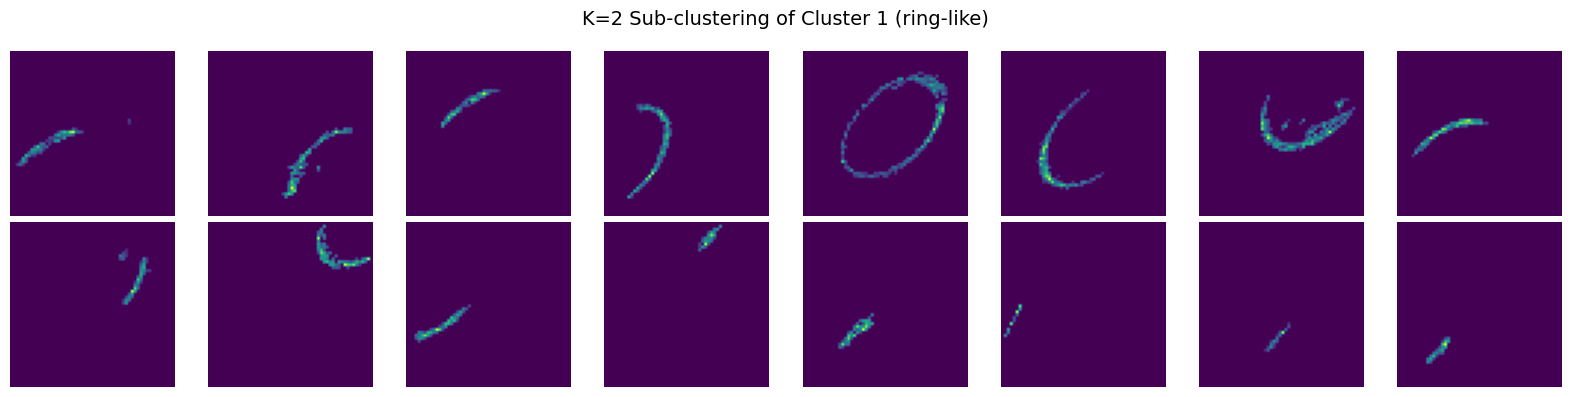

In [35]:
# Apply K-means (k=2) to Cluster 1 from previous k=2 clustering
k2_labels = kmeans_predictions[2]['train']
cluster1_mask = (k2_labels == 1)
cluster1_indices = np.where(cluster1_mask)[0]

print(f"Applying K-means (k=2) to Cluster 1 from k=2 clustering...")
print(f"Cluster 1 has {len(cluster1_indices)} events")

# Get features for Cluster 1
cluster1_features = features_train_pca[cluster1_indices]

# K-means with k=2
kmeans_subcluster = KMeans(n_clusters=2, random_state=42, n_init=10, max_iter=300)
subcluster_labels = kmeans_subcluster.fit_predict(cluster1_features)

print(f"\nSub-clustering results:")
print(f"  Sub-cluster 0: {(subcluster_labels == 0).sum()} events")
print(f"  Sub-cluster 1: {(subcluster_labels == 1).sum()} events")

# Visualize sub-clusters
fig, axes = plt.subplots(2, 8, figsize=(16, 4))
fig.suptitle("K=2 Sub-clustering of Cluster 1 (ring-like)", fontsize=14)

for sub_id in range(2):
    sub_indices = cluster1_indices[subcluster_labels == sub_id]
    n_samples = min(8, len(sub_indices))
    sample = np.random.choice(sub_indices, n_samples, replace=False)
    
    for j in range(8):
        if j < n_samples:
            axes[sub_id, j].imshow(x_train[sample[j]], cmap='viridis')
        axes[sub_id, j].axis('off')
        
    axes[sub_id, 0].set_ylabel(f'Sub-cluster {sub_id}\n({len(sub_indices)})', 
                               fontsize=10, rotation=0, ha='right', va='center')

plt.tight_layout()
plt.show()

## Hough transform

In [22]:
def detect_complete_rings_hough(images, min_radius_frac=0.10, max_radius_frac=0.40):
    """
    Use Hough transform to detect complete circular rings.
    Returns quality scores for each image (0 if no ring detected).
    """
    img_size = images[0].shape[0]
    min_radius = int(img_size * min_radius_frac)
    max_radius = int(img_size * max_radius_frac)
    radii = np.arange(min_radius, max_radius, step=2)
    
    ring_quality_scores = []
    
    print(f"Applying Hough transform to {len(images)} images...")
    print(f"Searching radii: {min_radius}-{max_radius} pixels")
    
    for img in tqdm(images):
        # Normalize
        img_norm = (img - img.min()) / (img.max() - img.min() + 1e-8)
        
        # Edge detection
        edges = canny(img_norm, sigma=2.0)
        
        # Hough circle detection
        hough_res = hough_circle(edges, radii)
        accums, cx, cy, rad = hough_circle_peaks(
            hough_res, radii, 
            min_xdistance=10,
            min_ydistance=10,
            threshold=0.5 * hough_res.max(),
            num_peaks=1
        )
        
        # Quality score
        if len(accums) > 0:
            quality = accums[0] / (2 * np.pi * rad[0])
            ring_quality_scores.append(quality)
        else:
            ring_quality_scores.append(0.0)
    
    ring_quality_scores = np.array(ring_quality_scores)
    
    detected = ring_quality_scores > 0
    print(f"\nRings detected: {detected.sum()} / {len(images)}")
    if detected.sum() > 0:
        print(f"Quality scores:")
        print(f"  25th percentile: {np.percentile(ring_quality_scores[detected], 25):.3f}")
        print(f"  Median: {np.percentile(ring_quality_scores[detected], 50):.3f}")
        print(f"  75th percentile: {np.percentile(ring_quality_scores[detected], 75):.3f}")
    
    return ring_quality_scores

# Cluster 1 is ring-like
ring_like_mask = (k2_labels == 1)
shower_only_mask = (k2_labels == 0)

print(f"\nCluster 1 (ring-like): {ring_like_mask.sum()} images")
print(f"Cluster 0 (shower-only): {shower_only_mask.sum()} images")

# Apply Hough to ring-like cluster
ring_like_images = x_train[ring_like_mask]
ring_scores = detect_complete_rings_hough(
    ring_like_images,
    min_radius_frac=HOUGH_MIN_RADIUS_FRACTION,
    max_radius_frac=HOUGH_MAX_RADIUS_FRACTION
)

# Apply percentile threshold
quality_threshold = np.percentile(ring_scores[ring_scores > 0], HOUGH_QUALITY_PERCENTILE)
is_complete_ring = ring_scores >= quality_threshold

print(f"\nComplete rings (>{HOUGH_QUALITY_PERCENTILE}th percentile): {is_complete_ring.sum()}")
print(f"Partial/mixed events: {(~is_complete_ring).sum()}")


Cluster 1 (ring-like): 667 images
Cluster 0 (shower-only): 5965 images
Applying Hough transform to 667 images...
Searching radii: 8-25 pixels


100%|██████████| 667/667 [00:02<00:00, 289.34it/s]


Rings detected: 665 / 667
Quality scores:
  25th percentile: 0.005
  Median: 0.005
  75th percentile: 0.006

Complete rings (>75th percentile): 236
Partial/mixed events: 431


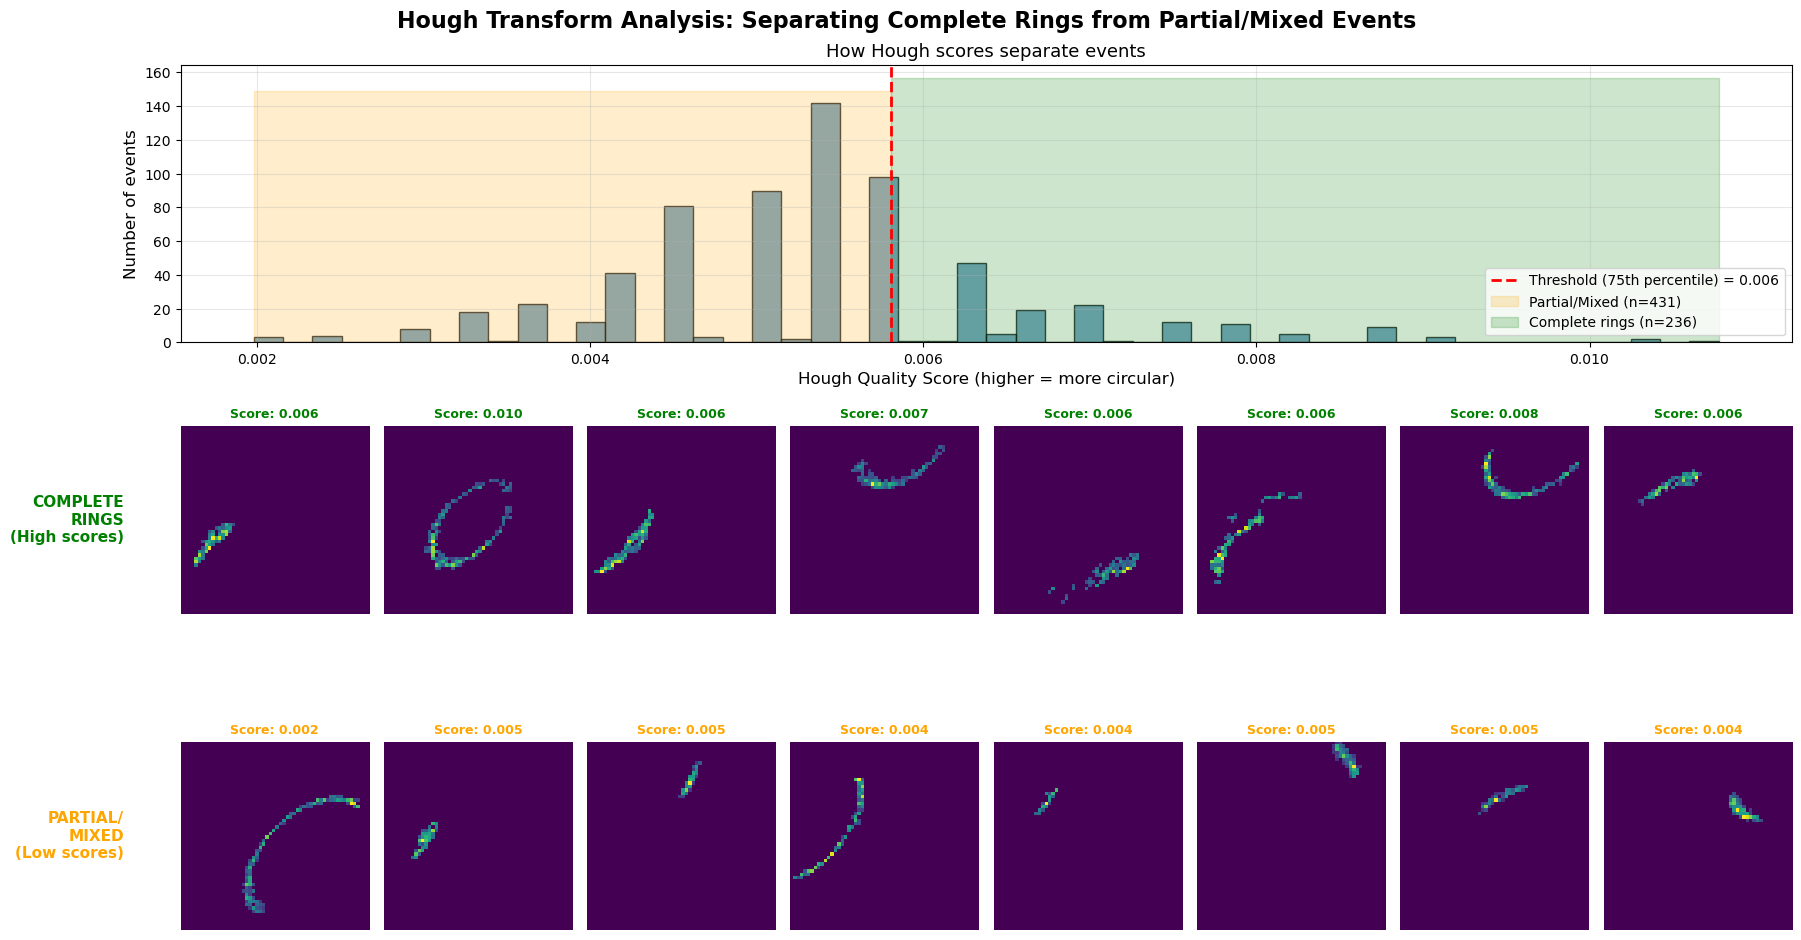

HOUGH TRANSFORM SUMMARY
Ring-like cluster (from K=2):    667 events
  ├─ Complete rings (circular):   236 events
  └─ Partial/mixed (not circular): 431 events

Shower-only cluster (from K=2):  5965 events


In [23]:
# Detailed Hough transform visualization

fig = plt.figure(figsize=(18, 10))

# Title
fig.suptitle('Hough Transform Analysis: Separating Complete Rings from Partial/Mixed Events', 
             fontsize=16, fontweight='bold')

# === Top: Score distribution ===
ax_hist = plt.subplot(3, 1, 1)
scores_detected = ring_scores[ring_scores > 0]
ax_hist.hist(scores_detected, bins=50, alpha=0.7, edgecolor='black', color='steelblue')
ax_hist.axvline(quality_threshold, color='red', linestyle='--', linewidth=2,
                label=f'Threshold ({HOUGH_QUALITY_PERCENTILE}th percentile) = {quality_threshold:.3f}')
ax_hist.fill_between([scores_detected.min(), quality_threshold], 0, ax_hist.get_ylim()[1], 
                      alpha=0.2, color='orange', label=f'Partial/Mixed (n={(~is_complete_ring).sum()})')
ax_hist.fill_between([quality_threshold, scores_detected.max()], 0, ax_hist.get_ylim()[1], 
                      alpha=0.2, color='green', label=f'Complete rings (n={is_complete_ring.sum()})')
ax_hist.set_xlabel('Hough Quality Score (higher = more circular)', fontsize=12)
ax_hist.set_ylabel('Number of events', fontsize=12)
ax_hist.set_title('How Hough scores separate events', fontsize=13)
ax_hist.legend(fontsize=10)
ax_hist.grid(True, alpha=0.3)

# === Middle: Complete rings (HIGH scores) ===
complete_indices = ring_like_indices[is_complete_ring]
n_show = min(8, len(complete_indices))
sample_complete = np.random.choice(complete_indices, n_show, replace=False)

for i in range(8):
    ax = plt.subplot(3, 8, 8 + i + 1)
    if i < n_show:
        idx = sample_complete[i]
        local_idx = np.where(complete_indices == idx)[0][0]
        score = ring_scores[is_complete_ring][local_idx]
        
        ax.imshow(x_train[idx], cmap='viridis')
        ax.set_title(f'Score: {score:.3f}', fontsize=9, color='green', fontweight='bold')
    ax.axis('off')
    if i == 0:
        ax.text(-0.3, 0.5, 'COMPLETE\nRINGS\n(High scores)', 
                transform=ax.transAxes, fontsize=11, fontweight='bold',
                ha='right', va='center', color='green')

# === Bottom: Partial/mixed (LOW scores) ===
partial_mixed_indices = ring_like_indices[~is_complete_ring]
n_show = min(8, len(partial_mixed_indices))
sample_partial = np.random.choice(partial_mixed_indices, n_show, replace=False)

for i in range(8):
    ax = plt.subplot(3, 8, 16 + i + 1)
    if i < n_show:
        idx = sample_partial[i]
        local_idx = np.where(partial_mixed_indices == idx)[0][0]
        score = ring_scores[~is_complete_ring][local_idx]
        
        ax.imshow(x_train[idx], cmap='viridis')
        ax.set_title(f'Score: {score:.3f}', fontsize=9, color='orange', fontweight='bold')
    ax.axis('off')
    if i == 0:
        ax.text(-0.3, 0.5, 'PARTIAL/\nMIXED\n(Low scores)', 
                transform=ax.transAxes, fontsize=11, fontweight='bold',
                ha='right', va='center', color='orange')

plt.tight_layout()
plt.show()

# Summary
print("="*70)
print("HOUGH TRANSFORM SUMMARY")
print("="*70)
print(f"Ring-like cluster (from K=2):    {len(ring_like_indices)} events")
print(f"  ├─ Complete rings (circular):   {is_complete_ring.sum()} events")
print(f"  └─ Partial/mixed (not circular): {(~is_complete_ring).sum()} events")
print(f"\nShower-only cluster (from K=2):  {shower_only_mask.sum()} events")
print("="*70)